In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
PARTICLE_TYPE = 'pion'

In [3]:
MODEL_NAME = "FastFastRICH_Cramer_{}_5layers".format(PARTICLE_TYPE)

In [4]:
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.display import clear_output
import scipy
from tqdm import tqdm_notebook, tqdm
from torch.autograd import Variable, grad
%matplotlib inline

In [5]:
import rich_utils.torch_utils_rich_mrartemev as utils_rich

## Data

In [6]:
data_train, data_val, scaler = utils_rich.get_merged_typed_dataset(PARTICLE_TYPE, dtype=np.float32, log=True)

Reading and concatenating datasets:
	../data/data_calibsample/pion_+_down_2016_.csv
	../data/data_calibsample/pion_-_down_2016_.csv
	../data/data_calibsample/pion2_+_up_2016_.csv
	../data/data_calibsample/pion_+_up_2016_.csv
	../data/data_calibsample/pion2_-_up_2016_.csv
	../data/data_calibsample/pion_-_up_2016_.csv
	../data/data_calibsample/pion2_+_down_2016_.csv
	../data/data_calibsample/pion2_-_down_2016_.csv
splitting to train/val/test
fitting the scaler
scaler train sample size: 2000000
scaler n_quantiles: 100000, time = 11.74782419204712
scaling train set
scaling test set
converting dtype to <class 'numpy.float32'>


In [7]:
BATCH_SIZE = int(1e3)
LATENT_DIMENSIONS = 64

In [8]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset

class RichDs(Dataset):
    def __init__(self, dataset, batch_size):
        self.dataset = torch.Tensor(dataset)
        self.batch_size = batch_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx=None):
        return self.dataset[idx]

In [9]:
train_full_ = RichDs(data_train.values[:,:-1], BATCH_SIZE)
w_full_ = RichDs(data_train.values[:,-1], BATCH_SIZE)
train_x_1_ = RichDs((data_train.values[:, utils_rich.y_count:])[:,:-1], BATCH_SIZE)
w_x_1_ = RichDs((data_train.values[:, utils_rich.y_count:])[:,-1], BATCH_SIZE)
train_x_2_ = RichDs((data_train.values[:, utils_rich.y_count:])[:,:-1], BATCH_SIZE)
w_x_2_ = RichDs((data_train.values[:, utils_rich.y_count:])[:,-1], BATCH_SIZE)

all_data = torch.utils.data.TensorDataset(train_full_.dataset, w_full_.dataset, train_x_1_.dataset, 
                                          w_x_1_.dataset, train_x_2_.dataset, w_x_2_.dataset)
all_dataloader = DataLoader(all_data, batch_size=BATCH_SIZE, shuffle=True)

## Model

In [10]:
CRAMER_DIM = 256
NUM_LAYERS = 5

class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear((LATENT_DIMENSIONS + data_train.shape[1] - 1 - utils_rich.y_count), 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, utils_rich.y_count)
        )

    def forward(self, input):
        noise = torch.empty(input.shape[0], LATENT_DIMENSIONS, device=input.device).normal_(mean=0,std=3.0)
        return self.main(torch.cat((noise, input), dim=1))

class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            nn.Linear((data_train.shape[1] - 1), 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, CRAMER_DIM)
        )

    def forward(self, input):
        output = self.main(input)
        return output

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [11]:
device = torch.device("cuda:3")
netG = Generator().to(device)
netC = Critic().to(device)
netC.apply(init_weights)
netG.apply(init_weights)
print('Ok')

Ok


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:48: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.


In [12]:
optC = torch.optim.RMSprop(netC.parameters(), lr=1e-3)
lr_C = torch.optim.lr_scheduler.ExponentialLR(optimizer=optC, gamma=0.98)
optG = torch.optim.RMSprop(netG.parameters(), lr=1e-3)
lr_G = torch.optim.lr_scheduler.ExponentialLR(optimizer=optG, gamma=0.98)

## Train

In [13]:
LOGDIR = "./log"
CRITIC_ITERATIONS_CONST = 15
CRITIC_ITERATIONS_VAR = 0
TOTAL_ITERATIONS = int(1e5)
VALIDATION_INTERVAL = 1000
critic_policy = lambda i: (
    CRITIC_ITERATIONS_CONST + (CRITIC_ITERATIONS_VAR * (TOTAL_ITERATIONS - i)) // TOTAL_ITERATIONS
)

In [14]:
def cramer_critic(x, y):
    discriminated_x = netC(x)
    return torch.norm(discriminated_x - netC(y), dim=1) - torch.norm(discriminated_x, dim=1)

In [15]:
lambda_pt = lambda i: 20 / np.pi * 2 * torch.atan(torch.tensor(i, dtype=torch.float32, device=device)/1e4)    

In [16]:
with torch.no_grad():
    N_VAL = int(3e5)
    validation_np = data_val.sample(N_VAL).values
    val = torch.tensor(validation_np, device=device)

In [ ]:
loss_c = []
loss_g = []

In [17]:
for epoch in tqdm(range(TOTAL_ITERATIONS), position=0, leave=True):
    for i, data in enumerate(all_dataloader):
        train_full, w_full, train_x_1, w_x_1, train_x_2, w_x_2 = data
        train_full = train_full.to(device)
        w_full = w_full.to(device)
        train_x_1 = train_x_1.to(device)
        w_x_1 = w_x_1.to(device)
        train_x_2 = train_x_2.to(device)
        w_x_2 = w_x_2.to(device)
        
        gen_y_1 = netG(train_x_1)
        gen_y_2 = netG(train_x_2)
        gen_full_2 = torch.cat((gen_y_2, train_x_2), dim=1)
        gen_full_1 = torch.cat((gen_y_1, train_x_1), dim=1)

        for j in range(critic_policy(epoch)):
            output = netC(train_full)
            generator_loss = torch.mean(cramer_critic(train_full, gen_full_2) * w_full * w_x_2 -
                        cramer_critic(gen_full_1, gen_full_2) * w_x_1  * w_x_2)

            alpha = torch.empty(train_full.shape[0], 1, device=device).normal_(0.0,1.0)
            interpolates = alpha * train_full + (1.0 - alpha) * gen_full_1
            disc_interpolates = cramer_critic(interpolates, gen_full_2)
            gradients = grad(outputs=disc_interpolates, inputs=interpolates, 
                             grad_outputs=torch.ones_like(disc_interpolates))[0]
            slopes = torch.norm(torch.reshape(gradients, (list(gradients[0].shape)[0], -1)), dim=1)
            gradient_penalty = torch.mean(torch.pow(torch.max(torch.abs(slopes) - 1, 
                                                              torch.zeros(8, device=device)), 2))
            critic_loss = lambda_pt(epoch) * gradient_penalty - generator_loss
            critic_loss.backward(retain_graph=True)
            optC.step()
            optC.zero_grad()
            lr_C.step()
            del slopes, gradient_penalty, gradients, alpha, generator_loss, output, interpolates,
            disc_interpolates, critic_loss

        generator_loss = torch.mean(cramer_critic(train_full, gen_full_2) * w_full * w_x_2 -
                                cramer_critic(gen_full_1, gen_full_2) * w_x_1  * w_x_2)
        generator_loss.backward()
        optG.step()
        optG.zero_grad()
        lr_G.step()
        del generator_loss
    torch.save({'netC_state_dict': netC.state_dict(),
                'netG_state_dict': netG.state_dict(),
                'optC_state_dict': optC.state_dict(),
                'optG_state_dict': optG.state_dict(),
                'lr_C_state_dict': lr_C.state_dict(),
                'lr_G_state_dict': lr_G.state_dict()
               }, LOGDIR)
    clear_output(False)
    with torch.no_grad():
        noise_t = torch.empty(val[:, utils_rich.y_count:-1].shape[0], 
                                      LATENT_DIMENSIONS, device=device).normal_(mean=0,std=3.0)

        y_t = netG(torch.cat((noise_t, val[:, utils_rich.y_count:-1]), dim=1))
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        for INDEX, ax in zip((0, 1, 3, 4), axes.flatten()):
            _, bins, _ = ax.hist(val[:, INDEX].cpu(), bins=100, label="data", normed=True,
                                 weights=val[:,-1].cpu())
            ax.hist(y_t[:, INDEX].cpu(), bins=bins, label="generated", alpha=0.5, normed=True,
                    weights=val[:,-1].cpu())
            ax.legend()
            ax.set_title(utils_rich.dll_columns[INDEX])
        plt.show()

  0%|          | 0/100000 [00:00<?, ?it/s]

KeyboardInterrupt: 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  import sys
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


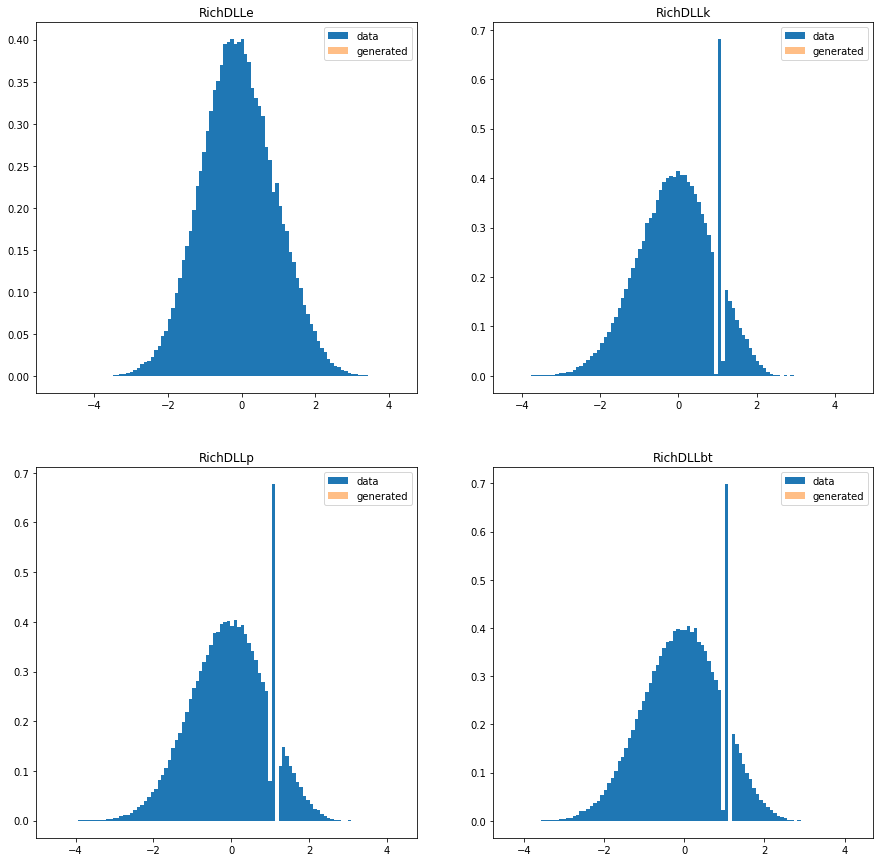

In [18]:
with torch.no_grad():

    y_t = netG(val[:, utils_rich.y_count:-1])
    fig, axes = plt.subplots(2, 2, figsize=(15, 15))
    for INDEX, ax in zip((0, 1, 3, 4), axes.flatten()):
        _, bins, _ = ax.hist(val[:, INDEX].cpu(), bins=100, label="data", normed=True,
                             weights=val[:,-1].cpu())
        ax.hist(y_t[:, INDEX].cpu(), bins=bins, label="generated", alpha=0.5, normed=True,
                weights=val[:,-1].cpu())
        ax.legend()
        ax.set_title(utils_rich.dll_columns[INDEX])
    plt.show()